['13', '108', '1000', '100', '1', '151.9', '0.0596047', '217.0', '3.559', '2.687e-23']
13 108 1000 100 1 151.9 0.0596047 217.0 3.559 2.687e-23
3.0 0.005 215.0
13 0.005 215.0
0.0999992641018 10.2598808475 1080.00794776 5.12994042377 0.7 9.0 3
6 18 0.333333333333 0.666666666667 -0.833333333333 -0.5
before loop 2.09442236488 -1.27876983601 time  215.0
1.05007261032 4.09773237564e-09
1.05007968343 8.37794256192e-09
1.05002574958 1.78282892893e-08
1.0500417923 1.83538235721e-08
1.05012056609 4.89243512369e-09
1.05017401409 7.85385179114e-09
1.05009693304 3.07072822725e-08
1.05003089204 5.80700221242e-09
1.05001360824 1.35194877515e-09
1.05004811105 2.89394841424e-09
after loop 1.66523306727 -0.997223716617 time  220.0


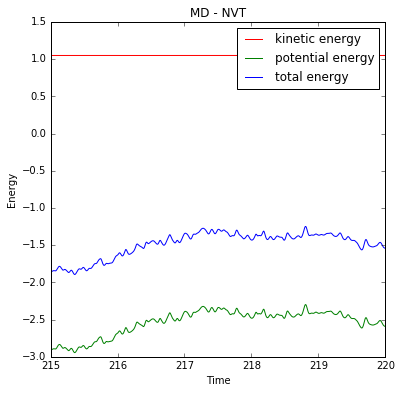

In [11]:
import math
import numpy as np
from md_routines import *
import string
import random
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
%matplotlib inline

#
#   project: molecular dynamics simulation of molecular fluids.
#   ========
#
#   program name: mdeq.f
#   =============
#
#   abstract
#   ========
#
#      this program performs a molecular dynamics simulation of the
#   lennard-jones fluid using fourth order predictor corrector
#   for integrating the equations of motion.  
#
#   programmer name: ptc
#   ================
#
#   version and date: 1.0, 04-05-1989 [fortran version]
#   ================= 0.9  06-23-2018 (jupyter notebook version)
#
#
#   key variables:
#   ==============
#
#   temp        temperature in units of degrees kelvin
#   tstar       dimensionless temperature ( = kt/eps)
#
#   rho         mass density in gm/cc
#   rstar       dimensionless density (= number density * sig**3)
#
#   eps         lennard-jones parameter energy parameter (= eps/k,
#               where k is Boltzmann's constant)
#
#   sig         lennard-jones distance parameter in angstroms
#
#   l           the length of the side of the simulation cell in
#               units of sig
#
#   mass        the mass of the molecules in gm
#
#   delt        the dimensionless time step
#
#   nmol        nmol = number of molecules
#
#   irun        run number.  if irun = 0, start from fcc crystal.
#
#   cutoff      the cutoff in units of sigma beyond which the potential
#               and force are equal to zero
#   
#   nvt         flag: if equal to 1, isokinetic (NVT)
#                     if equal to 0, contant energy (NVE)
#
# define variables by giving them initial null values
#

nmol,nstep,nblock,irun,nblock,nvt=0,0,0,0,0,0
boxlen,mdtmp,rho,eps,sig,mass,cutoff=0.0,0.0,0.0,0.0,0.0,0.0,0.0
delt,temp,halfl,vol,cutf2,shift=0.0,0.0,0.0,0.0,0.0,0.0
time = 0.0 # total time of simulation from first run in dimensionless units

blkavr=np.zeros((100,7))


# 
# read in mdeq.dat
#
irun,nmol,nstep,nblock,nvt,temp,rho,eps,sig,mass,cutoff,delt,time=read_mdeq_dat()
print irun, nmol, nstep, nblock, nvt, temp, rho, eps, sig, mass
print cutoff, delt, time
print irun, delt, time

#
# initialize all the arrays for position and momenta and derivatives
#
x0, y0, z0 = np.zeros(nmol), np.zeros(nmol), np.zeros(nmol)
x1, y1, z1 = np.zeros(nmol), np.zeros(nmol), np.zeros(nmol)
x2, y2, z2 = np.zeros(nmol), np.zeros(nmol), np.zeros(nmol)
x3, y3, z3 = np.zeros(nmol), np.zeros(nmol), np.zeros(nmol)
x4, y4, z4 = np.zeros(nmol), np.zeros(nmol), np.zeros(nmol)
px0, py0, pz0 = np.zeros(nmol), np.zeros(nmol), np.zeros(nmol)
px1, py1, pz1 = np.zeros(nmol), np.zeros(nmol), np.zeros(nmol)
px2, py2, pz2 = np.zeros(nmol), np.zeros(nmol), np.zeros(nmol)
px3, py3, pz3 = np.zeros(nmol), np.zeros(nmol), np.zeros(nmol)
px4, py4, pz4 = np.zeros(nmol), np.zeros(nmol), np.zeros(nmol)
traj_time=np.zeros(nstep)
traj_ke=np.zeros(nstep)
traj_pe=np.zeros(nstep)
traj_tot=np.zeros(nstep)

#
# initialize positions and velocities
#
tstar, rstar, cutf2, boxlen = md_start(nmol, rho, temp, eps, sig, mass, delt, cutoff,
      x0, y0, z0, x1, y1, z1, x2, y2, z2, x3, y3, z3, x4, y4, z4,
      px0, py0, pz0, px1, py1, pz1, px2, py2, pz2, px3, py3, pz3, px4, py4, pz4)
# 
# if this is not the first run, read in previous values of positions and momenta
#
if (irun > 0):
    read_prior_configuration(nmol,x0, y0, z0, x1, y1, z1, x2, y2, z2, x3, y3, z3, x4, y4, z4,
          px0, py0, pz0, px1, py1, pz1, px2, py2, pz2, px3, py3, pz3, px4, py4, pz4)
#
# now perform MD simulation for nstep timesteps in blocks of length nblock
#
print 'before loop', x0[0],pz0[0], 'time ', time
time = loop(nstep,nblock,nvt,blkavr,tstar,nmol,rho,temp,eps,sig,mass,delt,cutoff,cutf2,boxlen,time,
          x0, y0, z0, x1, y1, z1, x2, y2, z2, x3, y3, z3, x4, y4, z4,
          px0, py0, pz0, px1, py1, pz1, px2, py2, pz2, px3, py3, pz3, px4, py4, pz4,
            traj_time, traj_ke, traj_pe, traj_tot)
print 'after loop', x0[0],pz0[0], 'time ', time
irun = irun + 1
# 
# write out updated mdeq.dat
#
data_out = open('mdeq.dat','w') 
data_out.write('{}'.format(irun)+" "+'{}'.format(nmol)+" "+'{}'.format(nstep)\
               +" "+'{}'.format(nblock)+" "+'{}'.format(nvt)\
               +" "+'{}'.format(temp)+" "+'{}'.format(rho)\
               +" "+'{}'.format(eps)+" "+'{}'.format(sig)\
               +" "+'{}'.format(mass)+"\n")
data_out.write('{}'.format(cutoff)+" "+'{}'.format(delt)+" "+'{}'.format(time)+"\n")
data_out.close()  
#  
#   write the final configuration out to the file mdeq.con
#
write_final_configuration(nmol,x0, y0, z0, x1, y1, z1, x2, y2, z2, x3, y3, z3, x4, y4, z4,
          px0, py0, pz0, px1, py1, pz1, px2, py2, pz2, px3, py3, pz3, px4, py4, pz4)

#
# write out output for present run
#
run_output = open('mdeq.out', 'w')
run_output.write('Run number  '+'{}'.format(irun)+'  timestep '+'{}'.format(delt)+"\n")
run_output.write('Lennard-jones fluid: '+'{}'.format(nmol)\
                 +' molecules with eps/k = '+'{}'.format(eps)\
                 +' deg. K,'+"\n")
run_output.write('mass = '+'{}'.format(mass)\
                 +' gm and sig ='+'{}'.format(sig)\
                 +' Angstroms'+"\n")
run_output.write('Temperature = '+'{}'.format(temp)\
                 +' deg K, kT/eps = T* = '+'{}'.format(tstar)+"\n")
run_output.write('Density = '+'{}'.format(mass)\
                 +' gm/cc, rho*sig**3 ='+'{}'.format(rstar)+"\n\n")
run_output.write('Block averages are over '+'{}'.format(nblock)+' timesteps'+"\n\n")
run_output.write('  Time           k.e.       s.d.      p.e.'+\
                 '      s.d.         pressure   s.d.'+'\n')

#   write out averages of thermodynamic properties
#
ekinm = 0.0
ekinsd = 0.0
epotm = 0.0
epotsd = 0.0
presm = 0.0
pressd = 0.0
nb = nstep/nblock
for i in range(nb):
    run_output.write('{:10.4f}'.format(blkavr[i,6])+" "+'{:10.4f}'.format(blkavr[i,0])\
                     +"  "+'{:10.4e}'.format(blkavr[i,1])+" "+'{:10.4f}'.format(blkavr[i,2])\
                     +"  "+'{:10.4e}'.format(blkavr[i,3])+" "+'{:10.4f}'.format(blkavr[i,4])\
                     +"  "+'{:10.4e}'.format(blkavr[i,5])+"\n")
    ekinm = ekinm + blkavr[i,0]
    ekinsd = ekinsd + blkavr[i,0]**2
    epotm = epotm + blkavr[i,2]
    epotsd = epotsd + blkavr[i,2]**2
    presm = presm + blkavr[i,4]
    pressd = pressd + blkavr[i,4]**2
# end for i 
ekinm = ekinm/nb
ekinsd = math.sqrt(ekinsd/nb - ekinm**2)
epotm = epotm/nb
epotsd = math.sqrt(epotsd/nb - epotm**2)
presm = presm/nb
pressd = math.sqrt(pressd/nb - presm**2)
run_output.write("  Cumul.   "+'{:10.4f}'.format(ekinm)+"  "+'{:10.4e}'.format(ekinsd)\
                     +" "+'{:10.4f}'.format(epotm)+"  "+'{:10.4e}'.format(epotsd)\
                     +" "+'{:10.4f}'.format(presm)+"  "+'{:10.4e}'.format(pressd)+"\n")
run_output.close()




fig=plt.figure(figsize=(6,6))   
plt.plot(traj_time,traj_ke,color='r',label='kinetic energy')
plt.plot(traj_time,traj_pe,color='g',label='potential energy')
plt.plot(traj_time,traj_tot,color='b',label='total energy')

plt.ylabel('Energy')
plt.xlabel('Time')
plt.legend()
if (nvt == 1):
    plt.title('MD - NVT')
    fig.savefig('MD-LJ-NVT.tiff', format='tiff', dpi=1200)
else: 
    plt.title('MD - NVE')
    fig.savefig('MD-LJ-NVE.tiff', format='tiff', dpi=1200)
plt.show()





            


            
            
            




    
    

    



    












In [1]:
print range(1,3,1)

[1, 2]
